In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

from firedrake.petsc import PETSc

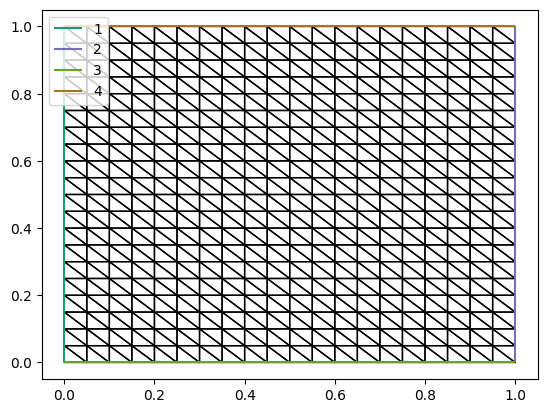

In [ ]:
n=20
mesh = UnitSquareMesh(n, n) #h=1/20=0.05
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [ ]:
V=VectorFunctionSpace(mesh,'P',2)
Q=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([V,Q])

x=SpatialCoordinate(mesh)

u_in=as_vector((x[1]*(1-x[1]),0))
u_noslip=Constant((0,0))
bc_in=DirichletBC(W.sub(0),u_in,1)
bc_noslip=DirichletBC(W.sub(0),u_noslip,3)
bc_freeslip=DirichletBC(W.sub(0).sub(1),Constant(0),4)
bcsU=(bc_in,bc_noslip,bc_freeslip)
nu=0.1
tangent=as_vector((-1,0))
alpha=0.01
f=Constant((0,0))

In [ ]:
def newton_linearizzation(u,v,p,q,u_old,nu,alpha,tangent):
  a=+dot(dot(grad(u),u_old),v)*dx\
    +dot(dot(grad(u_old),u),v)*dx\
    +2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
    -p*div(v)*dx\
    +q*div(u)*dx\
    +alpha*dot(u,tangent)*dot(v,tangent)*ds(4)
  L=dot(dot(grad(u_old),u_old),v)*dx
  return a,L

def stokes_initializzation(u,v,p,q,alpha,tangent,nu):
  a=+2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
  -p*div(v)*dx\
    +q*div(u)*dx\
    +alpha*dot(u,tangent)*dot(v,tangent)*ds(4)
  L=dot(f,v)*dx
  return a,L


def snes_solver(u,v,p,q,nu,alpha,tangent):
  G=+dot(dot(grad(u),u),v)*dx\
    +2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
    -p*div(v)*dx\
    +q*div(u)*dx\
    +alpha*dot(u,tangent)*dot(v,tangent)*ds(4)
  return G

In [ ]:
param = ( {'snes_type':'newtonls', # nonlinear solver types: https://petsc.org/release/manual/snes/#the-nonlinear-solvers
       'snes_monitor':'',        # activate logging options
       'snes_monitoring_lg_residualnorm':'', # print ||G|| at each iteration
       'snes_rtol':1e-4, 'snes_atol':1e-10, 'snes_stol':1e-14, 'snes_maxit':1000
       })

In [ ]:
u,p=TrialFunctions(W)
v,q=TestFunctions(W)

wh_init=Function(W)

a_stokes,L_stokes=stokes_initializzation(u,v,p,q,alpha,tangent,nu)
problem_stokes=LinearVariationalProblem(a_stokes,L_stokes,wh_init,bcsU)
solver_stokes=LinearVariationalSolver(problem_stokes)
solver_stokes.solve()
uh_init,ph_init=wh_init.subfunctions

wh=Function(W)
uh_old=Function(V)
ph_old=Function(Q)
uh_old.assign(uh_init)
ph_old.assign(ph_init)

a,L=newton_linearizzation(u,v,p,q,uh_old,nu,alpha,tangent)
problem=LinearVariationalProblem(a,L,wh,bcsU)
solver=LinearVariationalSolver(problem)


#snes_solver
wh_snes=Function(W)
uh_snes,ph_snes=split(wh_snes)
wh_snes.sub(0).assign(uh_init)  # for velocity
wh_snes.sub(1).assign(ph_init)
G=snes_solver(uh_snes,v,ph_snes,q,nu,alpha,tangent)
dwh=TrialFunction(W)
J=derivative(G,wh_snes,dwh)
problem_snes=NonlinearVariationalProblem(G,wh_snes,bcsU,J)
solver_snes=NonlinearVariationalSolver(problem_snes,solver_parameters=param)
#solver_snes.solve()
#uh_snes,ph_snes=wh_snes.subfunctions

In [ ]:
"""fig, ax = plt.subplots()
col = tripcolor(ph_snes, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh_snes, axes=ax)
plt.colorbar(col)
plt.title('velocity')"""

"fig, ax = plt.subplots()\ncol = tripcolor(ph_snes, axes=ax)\nplt.colorbar(col)\nplt.title('pressure')\nfig, ax = plt.subplots()\ncol = quiver(uh_snes, axes=ax)\nplt.colorbar(col)\nplt.title('velocity')"

In [ ]:
maxit = 100
it = 0
tol = 1e-6
err = tol+1     # >tol in order to enter the loop at the beginning

while it <= maxit and err > tol:

    it += 1
    print("it",it)
    uh_snes,ph_snes=split(wh_snes)
    G=snes_solver(uh_snes,v,ph_snes,q,nu,alpha,tangent)
    dwh=TrialFunction(W)
    J=derivative(G,wh_snes,dwh)
    problem_snes=NonlinearVariationalProblem(G,wh_snes,bcsU,J)
    solver_snes=NonlinearVariationalSolver(problem_snes,solver_parameters=param)
    solver_snes.solve()
    uh_snes,ph_snes=wh_snes.subfunctions

    err=norm(uh_snes,'H1')+norm(ph_snes,'L2')
    print("err",err)


it 1
  0 SNES Function norm 7.585957006722e-04
  1 SNES Function norm 2.146590296262e-06
  2 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 2
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 3
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 4
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 5
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 6
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 7
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 8
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 9
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 10
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 11
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 12
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it 13
  0 SNES Function norm 2.818849631409e-12
err 0.5057704153318368
it

Text(0.5, 1.0, 'velocity')

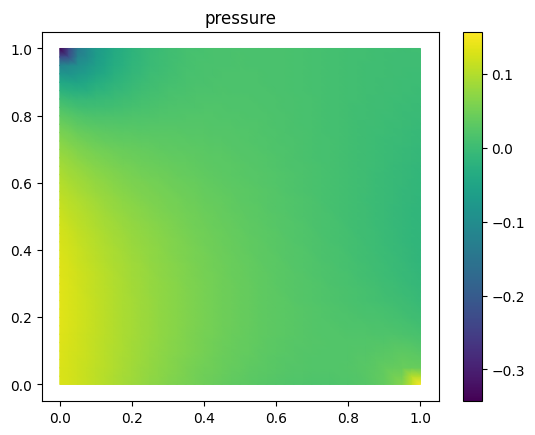

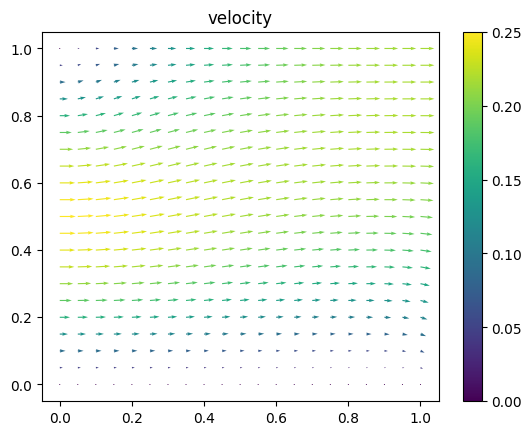

In [ ]:
fig, ax = plt.subplots()
col = tripcolor(ph_snes, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh_snes, axes=ax)
plt.colorbar(col)
plt.title('velocity')

In [ ]:
normal=FacetNormal(mesh)
drag_vec_3 = assemble( inner( ph*normal - 2.0*nu*dot(sym(grad(uh)), normal), Constant((1.,0.)) ) * ds(3) )
drag_vec_4 = assemble( inner( ph*normal - 2.0*nu*dot(sym(grad(uh)), normal), Constant((1.,0.)) ) * ds(4) )
print("drag_vec_3",drag_vec_3)
print("drag_vec_4",drag_vec_4)

ValueError: Multiple domains found, making the choice of integration domain ambiguous.